TUGAS KELOMPOK CBIR

In [1]:
import os, glob, json, math, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
# from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cosine, euclidean
# from tabulate import tabulate

# DATASET_DIR   = "/content/dataset"
DATASET_DIR   = "tugas_cbir/Rock-Paper-Scissors-images_archive"
TOP_K         = 5
USE_COSINE    = False #menggunakan eucleudian
MASK_BACKGROUND = True

WEIGHT_COLOR   = 1.0
WEIGHT_TEXTURE = 1.0
WEIGHT_SHAPE   = 1.0


MAX_PER_CLASS = 27

In [2]:
def list_images_by_class(root):
    items = []
    for cls in sorted(os.listdir(root)):
        p = os.path.join(root, cls)
        if os.path.isdir(p):
            for ext in ("*.jpg","*.jpeg","*.png"):
                for fp in glob.glob(os.path.join(p, ext)):
                    items.append((fp, cls))
    return items

dataset = list_images_by_class(DATASET_DIR)
assert dataset, f"error path {DATASET_DIR}"

#limit setiap class 27 total 81
if isinstance(MAX_PER_CLASS, int):
    kept, count = [], {}
    for path, cls in dataset:
        if count.get(cls, 0) < MAX_PER_CLASS:
            kept.append((path, cls))
            count[cls] = count.get(cls, 0) + 1
    dataset = kept
    print("Class :", count)
else:
    print(f"Menggunakan dataset lengkap {len(dataset)} images.")


Class : {'paper': 27, 'rock': 27, 'scissors': 27}


## Preprocess **masking**

In [4]:
def padding(img, kernel=5):
    pad_img = np.zeros( (img.shape[0]+kernel-1, img.shape[1]+kernel-1 ), dtype='uint8' )

    # buat citra noise sebelumnya dengan penambahan padding
    real_px = (kernel-1)//2
    for i in range( real_px, pad_img.shape[0] - real_px):
        for j in range( real_px, pad_img.shape[1] - real_px):
            pad_img[i][j] = img[i- real_px][j- real_px ]
    return pad_img

# buat fungsi spatial denoising
def spatial_denoising(ori_img, k=3, mode='mean'):
    # buat salinan citra dan simpan panjang dan lebarnya
    img = ori_img.copy()
    img = padding(img, kernel=k)
    # img = np.zeros( (img.shape[0]+2, img.shape[1]+2 ), dtype='uint8' )
    h_idx, w_idx = img.shape[0], img.shape[1]
    h_list = list()

    # memilih mode filter
    if mode == 'mean':
        val = 0
    elif mode == 'median':
        val = list()
    
    # lakukan filtering pada citra
    for h in range(h_idx):

        w_list = list()
        for w in range(w_idx):
            
            # pilih mode
            if mode == 'mean':
                val = 0
            elif mode == 'median':
                val = list()

            # lakukan filtering dengan kernel (3,3)
            for ii in range(k):
                is_break = False
                for jj in range(k):
                    try:
                        # pilih mode
                        if mode == 'mean':
                            # hitung rata-rata dari pixel
                            val += img[ii +h][jj +w] / (k*k)
                        elif mode == 'median':
                            # simpan nilai pixel
                            val.append( img[ii +h][jj +w] )
                    
                    # jika indexing melebih ukuran citra (index out of bound)
                    # maka hentikan proses filtering
                    except:
                        is_break = True
                        break
                if is_break:
                    break
            
            # pilih mode
            if mode == 'mean':
                # bulatkan nilai pixel
                val = round(val)
            elif mode == 'median':
                # urutkan nilai-nilai pixel lalu pilih nilai tengahnya
                val.sort()
                val = val[ len(val)// 2 ]

            # simpan nilai pixel sebagai nilai list
            w_list.append( val )
        # simpan nilai-nilai pixel sebagai baris
        # dengan mengabaikan 2 nilai/kolom terakhir
        h_list.append(w_list[:-2])

    # simpan citra sebagai numpy array
    # dengan mengabaikan 2 nilai/baris terakhir
    new_img = np.array(h_list[:-2], dtype='uint8')
    
    #kembailkan nilai
    return new_img

In [5]:
def otsu(gray):
    pixel_number = gray.shape[0] * gray.shape[1]
    mean_weigth = 1.0/pixel_number
    his, bins = np.histogram(gray, np.array(range(0, 256)))
    final_thresh = -1
    final_value = -1
    for t in bins[1:-1]:
        Wb = np.sum(his[:t]) * mean_weigth
        Wf = np.sum(his[t:]) * mean_weigth

        mub = np.mean(his[:t])
        muf = np.mean(his[t:])

        value = Wb * Wf * (mub - muf) ** 2

        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = gray.copy()
    final_img[gray > final_thresh] = 255
    final_img[gray < final_thresh] = 0
    return final_img


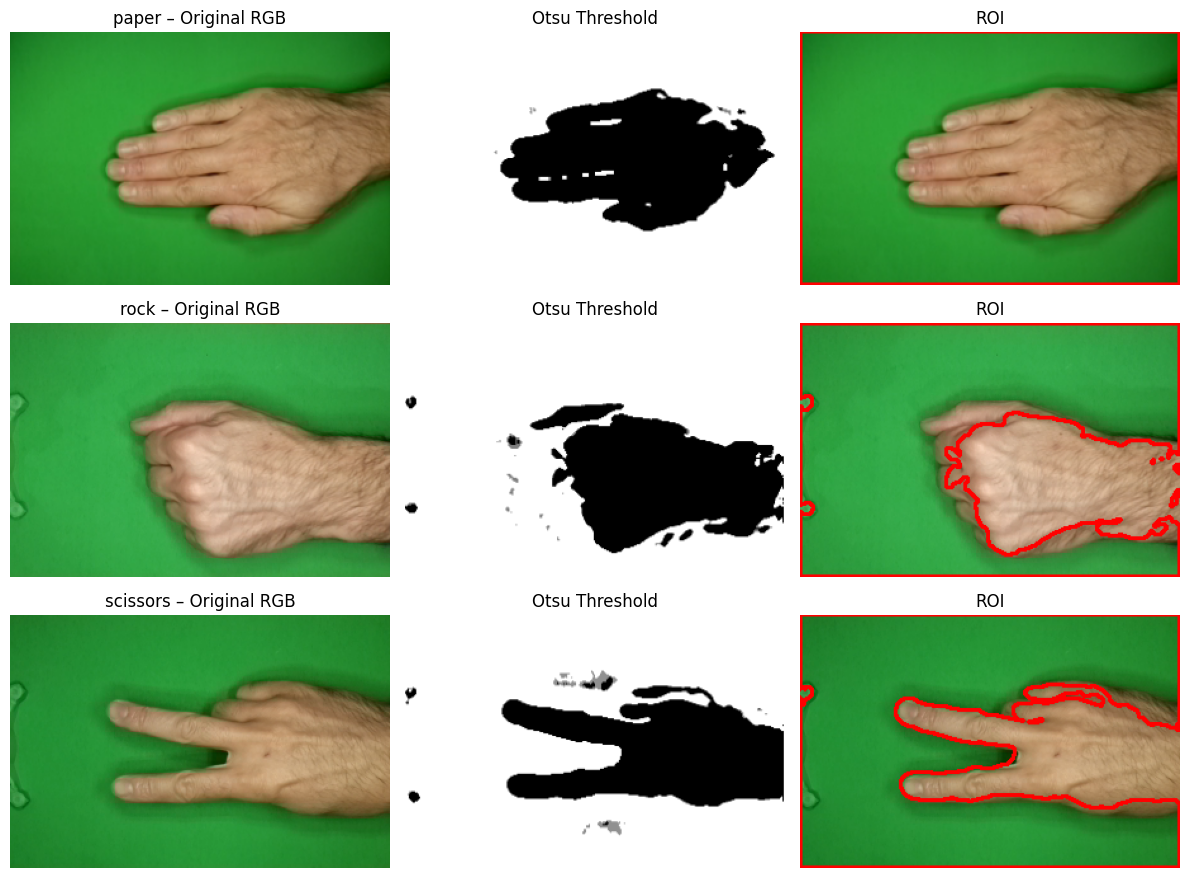

In [6]:
import matplotlib.pyplot as plt

def imread_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise ValueError(f"Error Path: {path}")
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def hand_mask_and_roi(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = spatial_denoising(gray, k=5, mode='median')
    th = otsu(blur)
    if (th==255).sum() < (th==0).sum():
        th = 255 - th

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        h, w = th.shape
        return np.zeros((h,w), np.uint8), img_rgb, th

    c = max(cnts, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    roi_img  = img_rgb[y:y+h, x:x+w].copy()
    roi_mask = th[y:y+h, x:x+w].copy()
    roi_mask = cv2.erode(roi_mask, np.ones((3,3), np.uint8), iterations=1)

    h, w = img_rgb.shape[:2]
    roi_img = cv2.resize(roi_img, dsize=(w, h))
    roi_mask = cv2.resize(roi_mask, dsize=(w, h))
    th = cv2.resize(th, dsize=(w, h))

    return roi_mask, roi_img, th

examples = {}
for path, cls in dataset:
    if cls not in examples:
        examples[cls] = path
    if len(examples) == 3:
        break

plt.figure(figsize=(12, 9))
for i, (cls, path) in enumerate(examples.items(), 1):
    # img = imread_rgb(path)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask, roi_img, th = hand_mask_and_roi(img)
    vis = roi_img.copy()
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(vis, cnts, -1, (255,0,0), 2)

    plt.subplot(3, 3, (i-1)*3 + 1)
    plt.imshow(img); plt.axis("off"); plt.title(f"{cls} – Original RGB")

    plt.subplot(3, 3, (i-1)*3 + 2)
    plt.imshow(th, cmap="gray"); plt.axis("off"); plt.title("Otsu Threshold")

    plt.subplot(3, 3, (i-1)*3 + 3)
    plt.imshow(vis); plt.axis("off"); plt.title("ROI")

plt.tight_layout()
plt.show()



In [7]:
img.shape[:2]

(200, 300)

## Fitur **Extraction**


In [8]:
def extract_color_features(img_rgb):
    # HSV 3D histogram (8-8-8) Mask contour digunakan tanpa backround
    if MASK_BACKGROUND:
        mask, roi_img, _ = hand_mask_and_roi(img_rgb)
        hsv = cv2.cvtColor(roi_img, cv2.COLOR_RGB2HSV)
        hist = cv2.calcHist([hsv], [0,1,2], mask, [8,8,8], [0,180, 0,256, 0,256])
    else:
        hsv  = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
        hist = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0,180, 0,256, 0,256])

    #normalisasi histogram
    hist = cv2.normalize(hist, hist).flatten()

    #aplikasi statistik mean, std, skew, kurt
    mean, std = hist.mean(), hist.std() + 1e-12
    skew = ((hist-mean)**3).mean() / (std**3)
    kurt = ((hist-mean)**4).mean() / (std**4)

    return np.concatenate(([mean, std, skew, kurt], hist)).astype("float32")

def extract_texture_features(img_rgb):
    # glcm pada roi tangan
    if MASK_BACKGROUND:
        mask, roi_img, _ = hand_mask_and_roi(img_rgb)

        # gray = (rgb2gray(roi_img) * 255).astype('uint8')
        gray = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)

        inpaint_mask = (mask == 0).astype('uint8') * 255
        gray_filled = cv2.inpaint(gray, inpaint_mask, 3, cv2.INPAINT_TELEA)
        base = gray_filled
    else:
        # base = (rgb2gray(img_rgb) * 255).astype('uint8')
        base = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    #aplikasi penggunaan 4 arah berbeda 0, 45, 90, 135
    glcm = graycomatrix(base, distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        symmetric=True, normed=True)
    feats = [graycoprops(glcm, p).mean() for p in ('contrast','correlation','energy','homogeneity')]
    return np.array(feats, dtype="float32")

def extract_shape_features(img_rgb):
   # Area, perimeter, aspect ratio, extent, solidity, circularity dari contour terbesar."""
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = spatial_denoising(gray, k=5, mode='median')
    th = otsu(blur)

    if (th==255).sum() < (th==0).sum():
        th = 255 - th

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return np.zeros(6, dtype="float32")
    c = max(cnts, key=cv2.contourArea)

    area = float(cv2.contourArea(c))
    peri = float(cv2.arcLength(c, True)) + 1e-8
    x,y,w,h = cv2.boundingRect(c)
    aspect = float(w) / max(h, 1)
    extent = area / max(w*h, 1)
    hull = cv2.convexHull(c)
    solidity = area / max(cv2.contourArea(hull), 1e-8)
    circularity = (4 * math.pi * area) / (peri**2)

    return np.array([area, peri, aspect, extent, solidity, circularity], dtype="float32")


## **Test Visualisasi extraksi fitur**

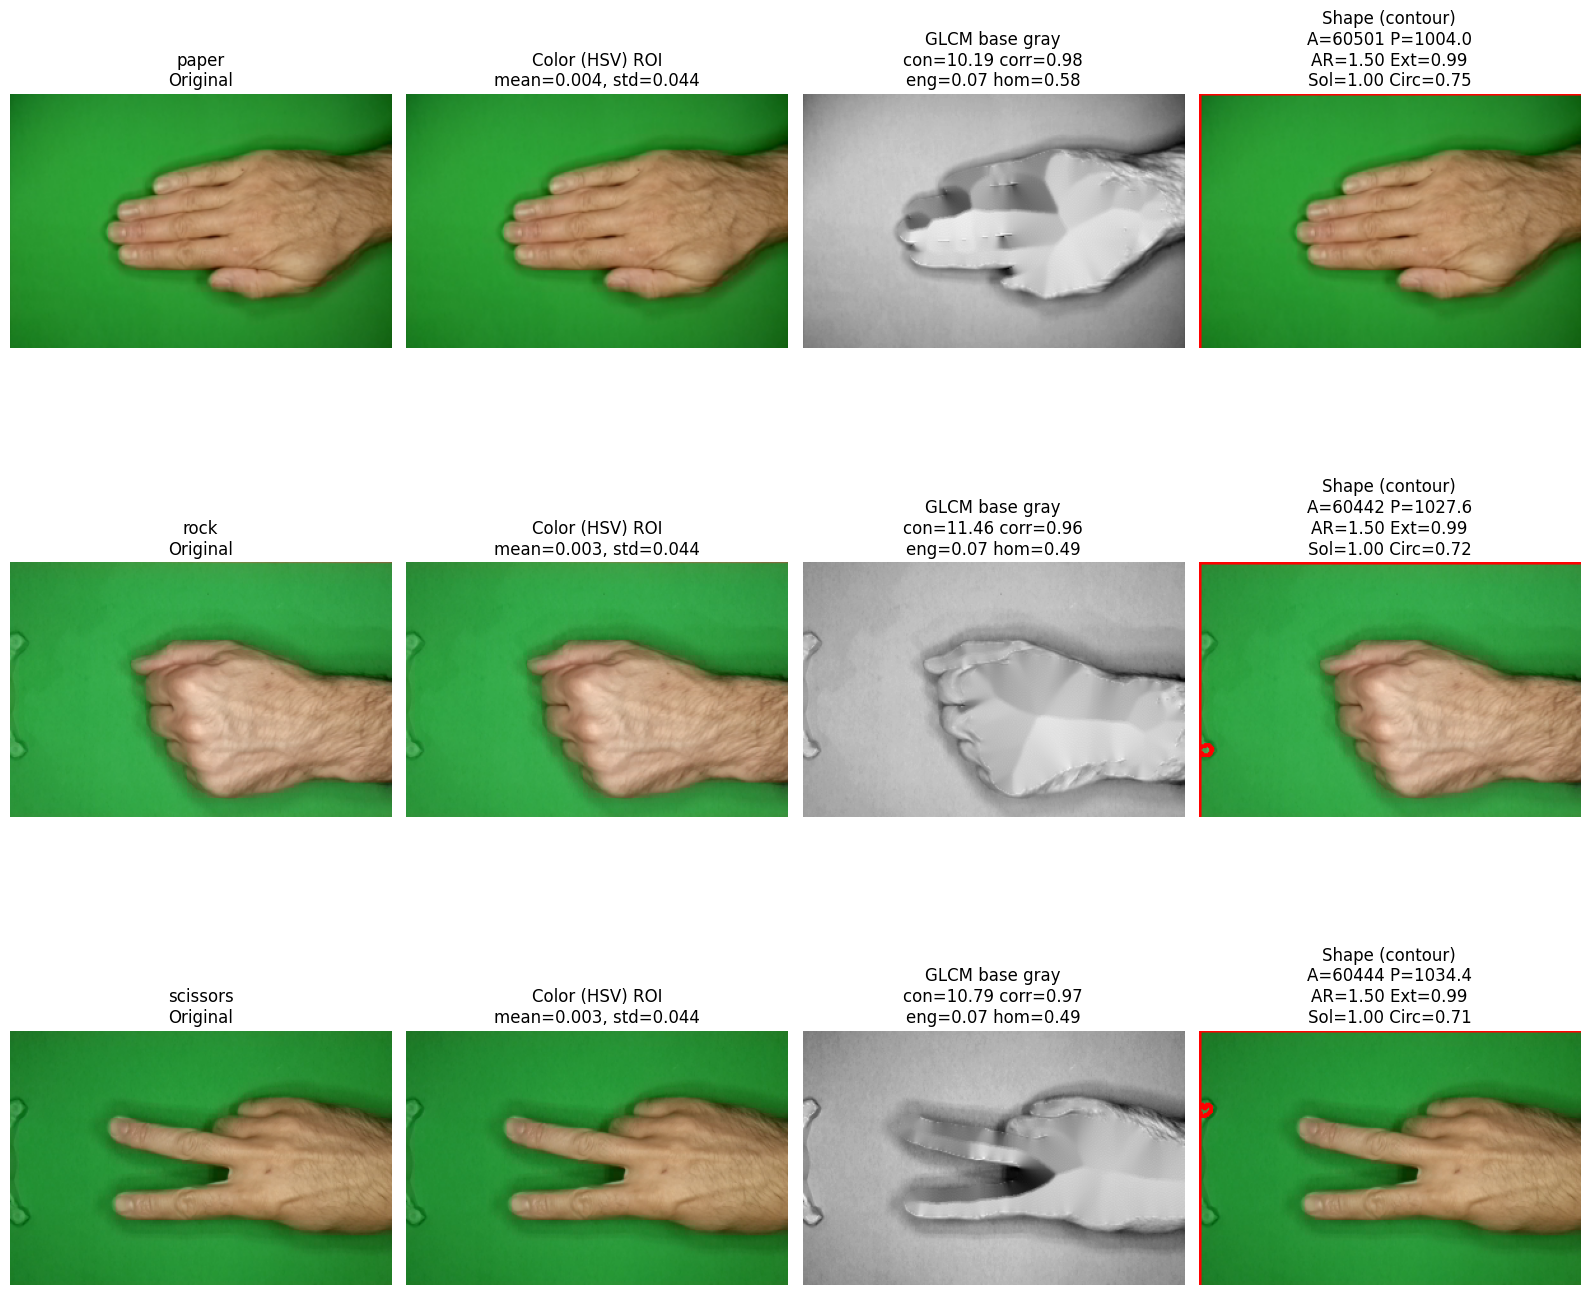

In [9]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

def visualisasi_ektraksi_class():
    examples = {}
    for path, cls in dataset:
        if cls not in examples:
            examples[cls] = path
        if len(examples) == 3:  # rock, paper, scissors
            break

    n_rows = len(examples)
    plt.figure(figsize=(16, 5 * n_rows))

    for r, (cls, path) in enumerate(examples.items(), start=1):
        img = imread_rgb(path)

        img = cv2.resize(img, dsize=(300, 200)) #interpolation=cv2.INTER_LINEAR)

        # mask roi
        roi_mask, roi_img, th_full = hand_mask_and_roi(img)

        # warna pada ROI mask
        if MASK_BACKGROUND:
            hsv = cv2.cvtColor(roi_img, cv2.COLOR_RGB2HSV)
            # print(hsv) ###
            # return hsv
            hsv = cv2.resize(hsv, dsize=(300, 200))
            roi_mask = cv2.resize(roi_mask, dsize=(300, 200))
            hist = cv2.calcHist([hsv], [0,1,2], roi_mask, [8,8,8], [0,180,0,256,0,256])
        else:
            hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            hsv = cv2.resize(hsv, dsize=(300, 200))
            hist = cv2.calcHist([hsv], [0,1,2], None, [8,8,8], [0,180,0,256,0,256])
        hist = cv2.normalize(hist, hist)


        hflat = hist.flatten()
        c_mean = float(hflat.mean())
        c_std  = float(hflat.std() + 1e-12)
        c_skew = float(((hflat - c_mean)**3).mean() / (c_std**3))
        c_kurt = float(((hflat - c_mean)**4).mean() / (c_std**4))


        # GLCM pada mask ROI inpainted (texture)
        if MASK_BACKGROUND:
            # gray_roi = (rgb2gray(roi_img) * 255).astype('uint8')
            gray_roi = cv2.cvtColor(roi_img, cv2.COLOR_RGB2GRAY)
            
            inpaint_mask = (roi_mask == 0).astype('uint8') * 255
            gray_tex = cv2.inpaint(gray_roi, inpaint_mask, 3, cv2.INPAINT_TELEA)
        else:
            # gray_tex = (rgb2gray(img) * 255).astype('uint8')
            gray_tex = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        glcm = graycomatrix(gray_tex, distances=[1],
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            symmetric=True, normed=True)
        t_contrast    = float(graycoprops(glcm, 'contrast').mean())
        t_correlation = float(graycoprops(glcm, 'correlation').mean())
        t_energy      = float(graycoprops(glcm, 'energy').mean())
        t_homogeneity = float(graycoprops(glcm, 'homogeneity').mean())

        # bentuk
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # blur = cv2.GaussianBlur(gray, (5,5), 0)
        blur = spatial_denoising(gray, k=5, mode='median')

        # _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        th = otsu(blur)        
        if (th==255).sum() < (th==0).sum():
            th = 255 - th
        cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        shape_vis = img.copy()
        if cnts:
            c = max(cnts, key=cv2.contourArea)
            cv2.drawContours(shape_vis, [c], -1, (255, 0, 0), 2)
            area = float(cv2.contourArea(c))
            peri = float(cv2.arcLength(c, True)) + 1e-8
            x,y,w,h = cv2.boundingRect(c)
            aspect = float(w) / max(h, 1)
            extent = area / max(w*h, 1)
            hull = cv2.convexHull(c)
            solidity = area / max(cv2.contourArea(hull), 1e-8)
            circularity = (4 * math.pi * area) / (peri**2)
        else:
            area = peri = aspect = extent = solidity = circularity = float('nan')

        # plotting
        # Oringinal
        ax = plt.subplot(n_rows, 4, (r - 1) * 4 + 1)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{cls}\nOriginal")

        # Warna
        ax = plt.subplot(n_rows, 4, (r - 1) * 4 + 2)
        if MASK_BACKGROUND:
            ax.imshow(cv2.cvtColor(roi_img, cv2.COLOR_RGB2BGR)[:,:,::-1])  #ROI
            tit = "Color (HSV) ROI"
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)[:,:,::-1])
            tit = "Color (HSV) Full"
        ax.axis("off"); ax.set_title(tit + f"\nmean={c_mean:.3f}, std={c_std:.3f}")

        # Tekstur GLSM
        ax = plt.subplot(n_rows, 4, (r - 1) * 4 + 3)
        ax.imshow(gray_tex, cmap="gray"); ax.axis("off")
        ax.set_title(f"GLCM base gray\ncon={t_contrast:.2f} corr={t_correlation:.2f}\neng={t_energy:.2f} hom={t_homogeneity:.2f}")

        # Bentuk
        ax = plt.subplot(n_rows, 4, (r - 1) * 4 + 4)
        ax.imshow(shape_vis); ax.axis("off")
        ax.set_title(f"Shape (contour)\nA={area:.0f} P={peri:.1f}\nAR={aspect:.2f} Ext={extent:.2f}\nSol={solidity:.2f} Circ={circularity:.2f}")

    plt.tight_layout()
    plt.show()


# uji = 
visualisasi_ektraksi_class()

Fitur database

In [10]:
db_color, db_tex, db_shape, db_meta = [], [], [], []

for path, cls in dataset:
    img = imread_rgb(path)
    img = cv2.resize(img, dsize=(300, 200))
    db_color.append(extract_color_features(img))
    db_tex.append(extract_texture_features(img))
    db_shape.append(extract_shape_features(img))
    db_meta.append((path, cls))

db_color = np.vstack(db_color)
db_tex   = np.vstack(db_tex)
db_shape = np.vstack(db_shape)

sc_color = StandardScaler().fit(db_color)
sc_tex   = StandardScaler().fit(db_tex)
sc_shape = StandardScaler().fit(db_shape)

db_color_s = sc_color.transform(db_color)
db_tex_s   = sc_tex.transform(db_tex)
db_shape_s = sc_shape.transform(db_shape)

db_combined = np.hstack([
    WEIGHT_COLOR*db_color_s,
    WEIGHT_TEXTURE*db_tex_s,
    WEIGHT_SHAPE*db_shape_s
])

print(f"Indexed {len(db_meta)} images.")


Indexed 81 images.


## **Retrieval dan Visualisasi (pencarian)**

In [11]:
def rank(db_feats, q_feat, topk=5, use_cosine=False):
    dists = []
    for i, f in enumerate(db_feats):
        d = cosine(q_feat, f) if use_cosine else euclidean(q_feat, f)
        dists.append((i, float(d)))
    dists.sort(key=lambda x: x[1])
    return dists[:topk]

def show_results(query_img, results, title="Results"):
    plt.figure(figsize=(13,3))
    plt.subplot(1, TOP_K+1, 1)
    plt.imshow(query_img); plt.axis("off"); plt.title("Query")
    for i, (idx, dist) in enumerate(results, start=1):
        img = imread_rgb(db_meta[idx][0])
        label = db_meta[idx][1]
        plt.subplot(1, TOP_K+1, i+1)
        plt.imshow(img); plt.axis("off")
        plt.title(f"#{i} {label}\n{dist:.2f}")
    plt.suptitle(title); plt.tight_layout(); plt.show()


In [12]:
import random
from collections import defaultdict

def queries_per_class(num_per_class=5, feature="combined", class_order=("rock","paper","scissors")):


    items_by_class = defaultdict(list)
    for path, cls in dataset:
        items_by_class[cls].append(path)


    def pick_feature_space(which):
        if which == "color":
            return db_color_s, lambda q: sc_color.transform([extract_color_features(q)])[0]
        if which == "glcm":
            return db_tex_s,   lambda q: sc_tex.transform([extract_texture_features(q)])[0]
        if which == "shape":
            return db_shape_s, lambda q: sc_shape.transform([extract_shape_features(q)])[0]

        # combined
        return db_combined, lambda q: np.concatenate([
            WEIGHT_COLOR  * sc_color.transform([extract_color_features(q)])[0],
            WEIGHT_TEXTURE* sc_tex.transform([extract_texture_features(q)])[0],
            WEIGHT_SHAPE  * sc_shape.transform([extract_shape_features(q)])[0],
        ])

    db_feats, qfeat_fn = pick_feature_space(feature)

    total_done = 0
    for cls in class_order:
        pool = items_by_class.get(cls, [])
        if not pool:
            print(f" error -  '{cls}'. lewatkan.")
            continue


        if len(pool) >= num_per_class:
            picks = random.sample(pool, num_per_class)
        else:
            picks = [random.choice(pool) for _ in range(num_per_class)]

        print(f"\n = {cls.upper()} QUERIES ({len(picks)} images) — fitur: {feature} = ")
        for i, q_path in enumerate(picks, start=1):
            q_img = imread_rgb(q_path)
            q_feat = qfeat_fn(q_img)

            results = rank(db_feats, q_feat, TOP_K, USE_COSINE) # 5 terbaik USE_COSINE == FALSE (EUCLIDEAN)

            print(f"\n[{cls} #{i}] Query: {os.path.basename(q_path)}")
            for rnk, (idx, dist) in enumerate(results, 1):
                lab = db_meta[idx][1]
                mark = "ok" if lab == cls else "--"
                print(f"  {rnk}. {os.path.basename(db_meta[idx][0]):18s} | {lab:10s} | {mark} | d={dist:.4f}")

            # hasil visualisasi Top-K k (k=5)
            show_results(q_img, results, title=f"{cls} query #{i} — Top-{TOP_K} ({feature})")

            total_done += 1

    print(f"\nDone. Total query: {total_done} (target {len(class_order)*num_per_class}).")

query combine (warna+glcm+bentuk)


 = ROCK QUERIES (1 images) — fitur: combined = 

[rock #1] Query: 2j9iOcnxJzcyaFB5.png
  1. 2j9iOcnxJzcyaFB5.png | rock       | ok | d=0.0000
  2. 0RA9rcrv8iVvuDDU.png | paper      | -- | d=18.1980
  3. 04l5I8TqdzF9WDMJ.png | paper      | -- | d=18.3643
  4. 1yeoLbmp4alVOtFv.png | paper      | -- | d=19.8082
  5. 2EAkMCm7ZLnNoBQ7.png | rock       | ok | d=21.6629


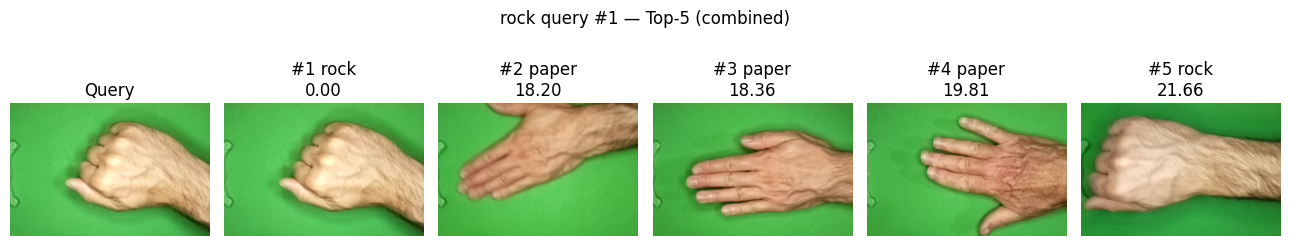


 = PAPER QUERIES (1 images) — fitur: combined = 

[paper #1] Query: 2PAcPusQ59xIMfiw.png
  1. 2PAcPusQ59xIMfiw.png | paper      | ok | d=0.0000
  2. 2F8Ng7620ANA7tEK.png | paper      | ok | d=6.6293
  3. 14K62H4KG1hg5qiJ.png | paper      | ok | d=10.8503
  4. 2DQbLQfHlfrcATqi.png | paper      | ok | d=11.1408
  5. 2EAkMCm7ZLnNoBQ7.png | rock       | -- | d=12.5690


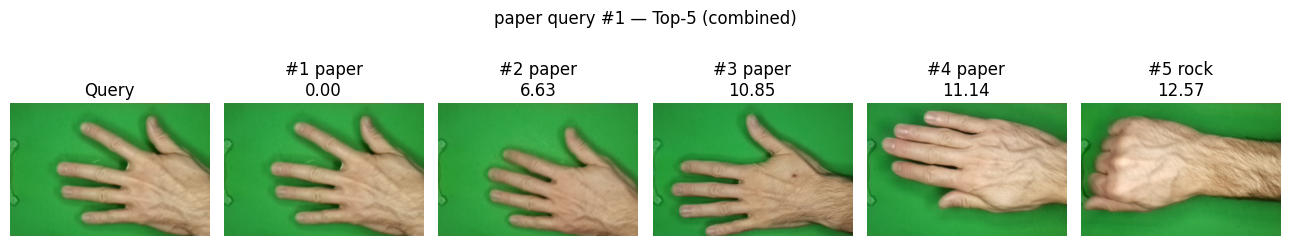


 = SCISSORS QUERIES (1 images) — fitur: combined = 

[scissors #1] Query: 1jKhi65BPTLXnUI6.png
  1. 1jKhi65BPTLXnUI6.png | scissors   | ok | d=0.0000
  2. 0657zSfiTYzP2jrl.png | scissors   | ok | d=3.3689
  3. I1T89xw2qr4aTrzq.png | rock       | -- | d=3.4687
  4. 1i1dlQrE6JnhYXE4.png | scissors   | ok | d=4.2469
  5. 1CXgK9fgGdSRggD9.png | scissors   | ok | d=4.8687


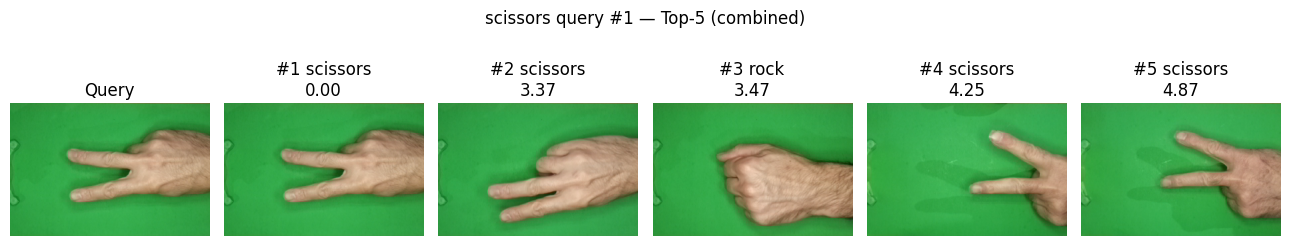


Done. Total query: 3 (target 3).


In [13]:
queries_per_class(num_per_class=1, feature="combined", class_order=("rock","paper","scissors"))

query color HSV


 = ROCK QUERIES (1 images) — fitur: color = 

[rock #1] Query: 1BqjHe5igJAgUjiN.png
  1. 1BqjHe5igJAgUjiN.png | rock       | ok | d=0.0000
  2. 0Flw60Z2MAWWKn6S.png | scissors   | -- | d=5.4325
  3. 1MMkSW3f1CAsw03q.png | scissors   | -- | d=5.4542
  4. 1L1n6plr7jlZGirw.png | scissors   | -- | d=5.5385
  5. 0t08v9bAaA0mXGCQ.png | paper      | -- | d=5.6201


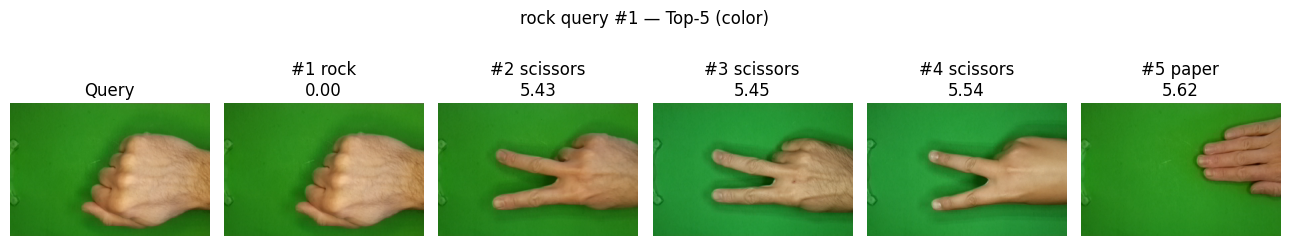


 = PAPER QUERIES (1 images) — fitur: color = 

[paper #1] Query: 0vugygEjxQJPr9yz.png
  1. 0vugygEjxQJPr9yz.png | paper      | ok | d=0.0000
  2. 138Tx9KlEfheT3uB.png | scissors   | -- | d=23.8660
  3. 2DQbLQfHlfrcATqi.png | paper      | ok | d=25.3365
  4. 14K62H4KG1hg5qiJ.png | paper      | ok | d=26.0686
  5. 1i1dlQrE6JnhYXE4.png | scissors   | -- | d=26.2790


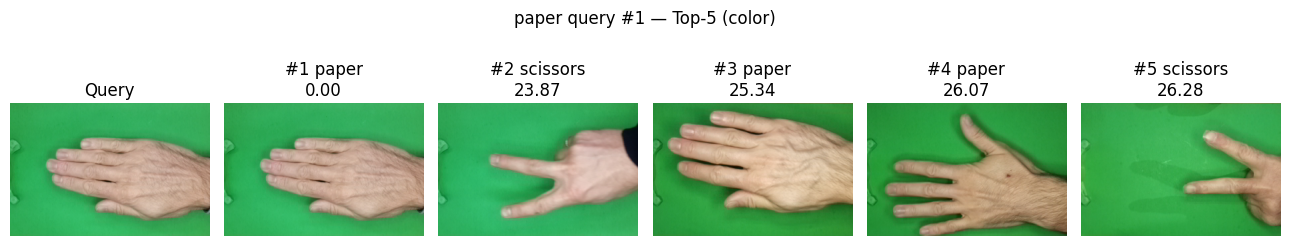


 = SCISSORS QUERIES (1 images) — fitur: color = 

[scissors #1] Query: 0Flw60Z2MAWWKn6S.png
  1. 0Flw60Z2MAWWKn6S.png | scissors   | ok | d=0.0000
  2. 1BqjHe5igJAgUjiN.png | rock       | -- | d=5.4325
  3. 1yKjzquSvl9ShK7K.png | paper      | -- | d=6.1202
  4. 2DEYFsJ27UgVqv3W.png | scissors   | ok | d=6.1208
  5. 1L1n6plr7jlZGirw.png | scissors   | ok | d=6.5137


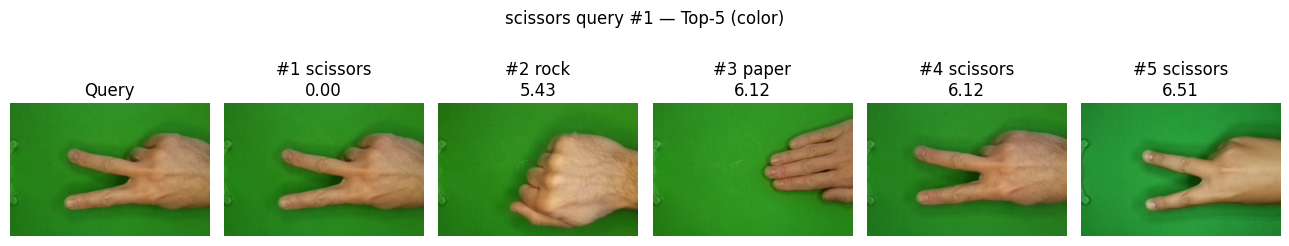


Done. Total query: 3 (target 3).


In [14]:
queries_per_class(num_per_class=1, feature="color", class_order=("rock","paper","scissors"))


query glcm tekstur


 = ROCK QUERIES (1 images) — fitur: glcm = 

[rock #1] Query: 1vvcitV1s17gKdbn.png
  1. 1vvcitV1s17gKdbn.png | rock       | ok | d=0.0000
  2. 2DdERUV7Te8ivywq.png | rock       | ok | d=0.2964
  3. 2affjOmZChc9AXpR.png | rock       | ok | d=0.3125
  4. 0Flw60Z2MAWWKn6S.png | scissors   | -- | d=0.3473
  5. 1L1n6plr7jlZGirw.png | scissors   | -- | d=0.3821


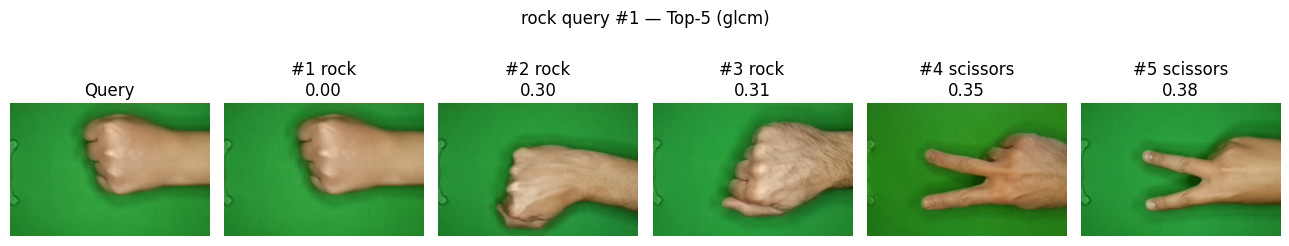


 = PAPER QUERIES (1 images) — fitur: glcm = 

[paper #1] Query: 2IOsxsG8AaxntdJM.png
  1. 2IOsxsG8AaxntdJM.png | paper      | ok | d=0.0000
  2. 1DxbXT3M2qiMjCmC.png | rock       | -- | d=0.4220
  3. 2OCAZGNv2OEzgAwU.png | paper      | ok | d=0.4403
  4. 0eqArS2GgsBeqgSn.png | paper      | ok | d=0.4502
  5. HU7Q4utMI0vHMxlh.png | paper      | ok | d=0.4787


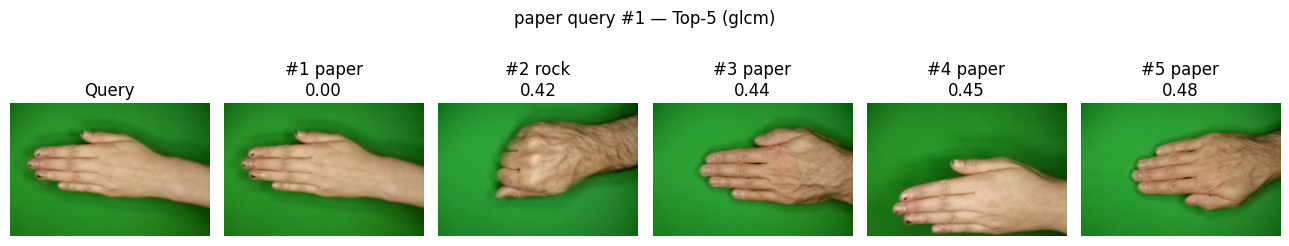


 = SCISSORS QUERIES (1 images) — fitur: glcm = 

[scissors #1] Query: 0CSaM2vL2cWX6Cay.png
  1. 0CSaM2vL2cWX6Cay.png | scissors   | ok | d=0.0000
  2. 0ePX1wuCc3et7leL.png | scissors   | ok | d=0.4562
  3. 277q9TUTAsBAbTCj.png | scissors   | ok | d=0.7413
  4. 17HZDUFSVPxcar99.png | scissors   | ok | d=0.7704
  5. 1VRzspyXpQ6A2rKy.png | scissors   | ok | d=0.8478


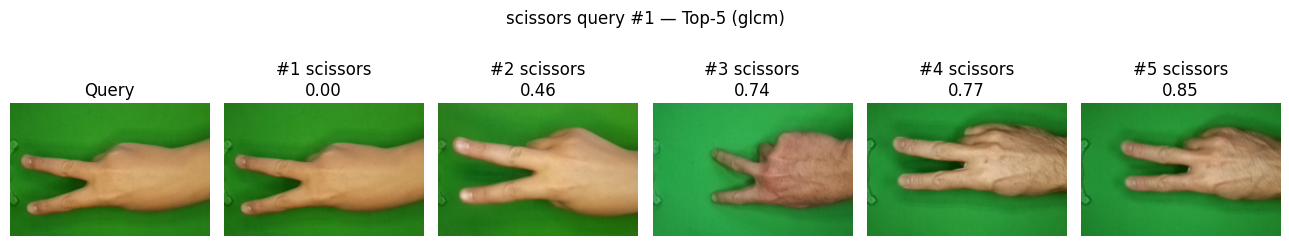


Done. Total query: 3 (target 3).


In [15]:
queries_per_class(num_per_class=1, feature="glcm", class_order=("rock","paper","scissors"))


Query Bentuk (threshold)


 = ROCK QUERIES (1 images) — fitur: shape = 

[rock #1] Query: 2f25VA1nfxiC86xj.png
  1. HU7Q4utMI0vHMxlh.png | paper      | -- | d=0.0000
  2. 0a3UtNzl5Ll3sq8K.png | paper      | -- | d=0.0000
  3. 0cb6cVL8pkfi4wF6.png | paper      | -- | d=0.0000
  4. 0eqArS2GgsBeqgSn.png | paper      | -- | d=0.0000
  5. 0Og76sl5CJhbxWWx.png | paper      | -- | d=0.0000


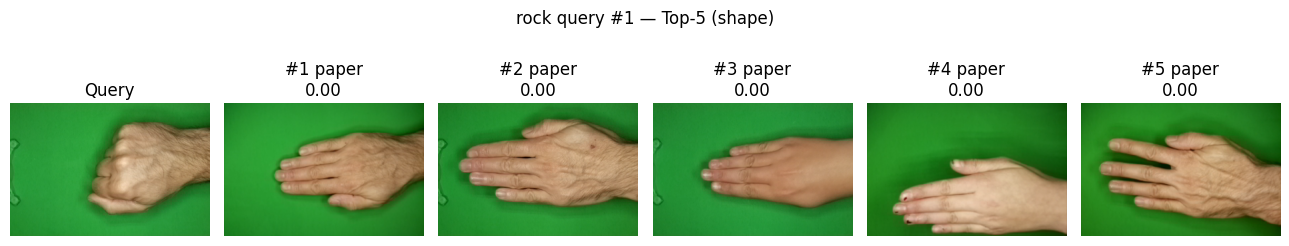


 = PAPER QUERIES (1 images) — fitur: shape = 

[paper #1] Query: 0Og76sl5CJhbxWWx.png
  1. HU7Q4utMI0vHMxlh.png | paper      | ok | d=0.0000
  2. 0a3UtNzl5Ll3sq8K.png | paper      | ok | d=0.0000
  3. 0cb6cVL8pkfi4wF6.png | paper      | ok | d=0.0000
  4. 0eqArS2GgsBeqgSn.png | paper      | ok | d=0.0000
  5. 0Og76sl5CJhbxWWx.png | paper      | ok | d=0.0000


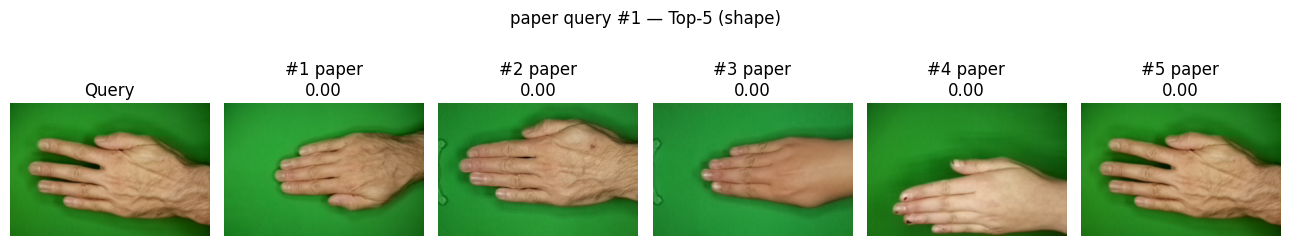


 = SCISSORS QUERIES (1 images) — fitur: shape = 

[scissors #1] Query: 0Flw60Z2MAWWKn6S.png
  1. 0CSaM2vL2cWX6Cay.png | scissors   | ok | d=0.0000
  2. 0Flw60Z2MAWWKn6S.png | scissors   | ok | d=0.0000
  3. 2DEYFsJ27UgVqv3W.png | scissors   | ok | d=0.0017
  4. 1BqjHe5igJAgUjiN.png | rock       | -- | d=0.0454
  5. HU7Q4utMI0vHMxlh.png | paper      | -- | d=0.0484


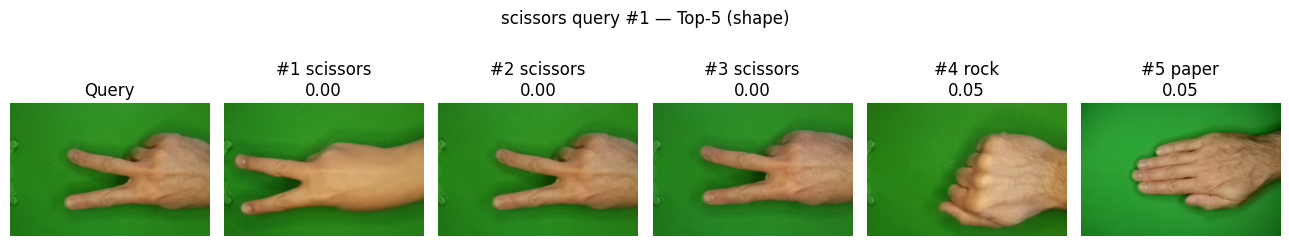


Done. Total query: 3 (target 3).


In [16]:
queries_per_class(num_per_class=1, feature="shape", class_order=("rock","paper","scissors"))


## **Evaluasi p@5

In [17]:
def evaluate_precision_from_block8(num_per_class=5, feature="combined", class_order=("rock","paper","scissors")):
    """
    Evaluate Precision@5 using the same 15 queries (5 per class).
    Each query compares against the full dataset.
    """

    from collections import defaultdict
    import numpy as np


    items_by_class = defaultdict(list)
    for path, cls in dataset:
        items_by_class[cls].append(path)


    def pick_feature_space(which):
        if which == "color":
            return db_color_s, lambda q: sc_color.transform([extract_color_features(q)])[0]
        if which == "glcm":
            return db_tex_s,   lambda q: sc_tex.transform([extract_texture_features(q)])[0]
        if which == "shape":
            return db_shape_s, lambda q: sc_shape.transform([extract_shape_features(q)])[0]
        # combined
        return db_combined, lambda q: np.concatenate([
            WEIGHT_COLOR  * sc_color.transform([extract_color_features(q)])[0],
            WEIGHT_TEXTURE* sc_tex.transform([extract_texture_features(q)])[0],
            WEIGHT_SHAPE  * sc_shape.transform([extract_shape_features(q)])[0],
        ])

    db_feats, qfeat_fn = pick_feature_space(feature)


    queries = []
    for cls in class_order:
        pool = items_by_class.get(cls, [])
        if not pool:
            continue
        if len(pool) >= num_per_class:
            picks = random.sample(pool, num_per_class)
        else:
            picks = [random.choice(pool) for _ in range(num_per_class)]
        for p in picks:
            queries.append((p, cls))


    results_table = []
    for q_path, q_cls in queries:
        q_img = imread_rgb(q_path)
        q_feat = qfeat_fn(q_img)
        ranked = rank(db_feats, q_feat, TOP_K, USE_COSINE)
        p5 = sum(db_meta[idx][1] == q_cls for idx, _ in ranked) / TOP_K
        results_table.append((os.path.basename(q_path), q_cls, p5))


    per_class = defaultdict(list)
    for _, cls, p in results_table:
        per_class[cls].append(p)
    print("\nPrecision@5 per Query:")
    for qname, cls, p5 in results_table:
        print(f"{cls:10s} | {qname:20s} | P@5 = {p5:.2f}")

    print("\nAverage P@5 per Class:")
    for cls, vals in per_class.items():
        print(f"  {cls:10s}: {np.mean(vals):.3f}")

    macro = np.mean([np.mean(v) for v in per_class.values()])
    print(f"\nMacro-average Precision@5 {len(queries)} queries: {macro:.3f}")


P@5 Gabungan

In [18]:
evaluate_precision_from_block8(num_per_class=5, feature="combined")


Precision@5 per Query:
rock       | 2affjOmZChc9AXpR.png | P@5 = 0.60
rock       | I1T89xw2qr4aTrzq.png | P@5 = 0.20
rock       | 1DxbXT3M2qiMjCmC.png | P@5 = 0.20
rock       | 1WuMUpzupKs67q29.png | P@5 = 0.60
rock       | 2DdERUV7Te8ivywq.png | P@5 = 0.60
paper      | 0vugygEjxQJPr9yz.png | P@5 = 0.80
paper      | 0Uomd0HvOB33m47I.png | P@5 = 0.40
paper      | 1Frbe8cdOdkciOBg.png | P@5 = 0.20
paper      | 1Dfw5FRlS4h60JPX.png | P@5 = 0.20
paper      | 27XFtQjjXQ8AP8Tl.png | P@5 = 0.80
scissors   | 0CSaM2vL2cWX6Cay.png | P@5 = 0.60
scissors   | 1L1n6plr7jlZGirw.png | P@5 = 0.80
scissors   | 1vQCX4af6hQmuwxZ.png | P@5 = 0.40
scissors   | 2C9FEbBklwcVhF3W.png | P@5 = 0.20
scissors   | 1yDUM1w2HTbuPIfO.png | P@5 = 0.60

Average P@5 per Class:
  rock      : 0.440
  paper     : 0.480
  scissors  : 0.520

Macro-average Precision@5 15 queries: 0.480


P@5 glcm

In [93]:
evaluate_precision_from_block8(num_per_class=5, feature="glcm")


Precision@5 per Query:
rock       | 1vvcitV1s17gKdbn.png | P@5 = 0.60
rock       | 19H63c0MWD56EWNq.png | P@5 = 0.20
rock       | 2f25VA1nfxiC86xj.png | P@5 = 0.60
rock       | 1wk2Hl1Ih9guOwx6.png | P@5 = 0.60
rock       | 1mnAKQCHEDbtjPX2.png | P@5 = 0.20
paper      | 1yeoLbmp4alVOtFv.png | P@5 = 0.80
paper      | 1Dfw5FRlS4h60JPX.png | P@5 = 0.20
paper      | 14K62H4KG1hg5qiJ.png | P@5 = 0.60
paper      | 0t08v9bAaA0mXGCQ.png | P@5 = 0.60
paper      | 0eqArS2GgsBeqgSn.png | P@5 = 0.60
scissors   | 1vQCX4af6hQmuwxZ.png | P@5 = 0.60
scissors   | 1MMkSW3f1CAsw03q.png | P@5 = 0.80
scissors   | 0CSaM2vL2cWX6Cay.png | P@5 = 1.00
scissors   | 2C9FEbBklwcVhF3W.png | P@5 = 0.60
scissors   | 0657zSfiTYzP2jrl.png | P@5 = 0.60

Average P@5 per Class:
  rock      : 0.440
  paper     : 0.560
  scissors  : 0.720

Macro-average Precision@5 15 queries: 0.573


P@5 bentuk

In [94]:
evaluate_precision_from_block8(num_per_class=5, feature="shape")


Precision@5 per Query:
rock       | 02vG75hQW9Vp4oTl.png | P@5 = 0.60
rock       | 0bioBZYFCXqJIulm.png | P@5 = 0.20
rock       | 2affjOmZChc9AXpR.png | P@5 = 0.00
rock       | 0NDYNEoDui7o64gU.png | P@5 = 0.40
rock       | 2j9iOcnxJzcyaFB5.png | P@5 = 0.20
paper      | 2DQbLQfHlfrcATqi.png | P@5 = 0.60
paper      | 1fKclJk4eBWOQSR1.png | P@5 = 0.40
paper      | 1yKjzquSvl9ShK7K.png | P@5 = 0.20
paper      | 0a3UtNzl5Ll3sq8K.png | P@5 = 1.00
paper      | 1Dfw5FRlS4h60JPX.png | P@5 = 1.00
scissors   | 1jKhi65BPTLXnUI6.png | P@5 = 0.00
scissors   | 1wZUIsowmZRmESjh.png | P@5 = 0.80
scissors   | 1lEpWTJDphkm3HdC.png | P@5 = 0.60
scissors   | 1vQCX4af6hQmuwxZ.png | P@5 = 0.00
scissors   | 17HZDUFSVPxcar99.png | P@5 = 0.80

Average P@5 per Class:
  rock      : 0.280
  paper     : 0.640
  scissors  : 0.440

Macro-average Precision@5 15 queries: 0.453


P@5 warna

In [95]:
evaluate_precision_from_block8(num_per_class=5, feature="color")



Precision@5 per Query:
rock       | 1vvcitV1s17gKdbn.png | P@5 = 0.60
rock       | I1T89xw2qr4aTrzq.png | P@5 = 0.20
rock       | 2DdERUV7Te8ivywq.png | P@5 = 0.60
rock       | 2f25VA1nfxiC86xj.png | P@5 = 0.40
rock       | 02vG75hQW9Vp4oTl.png | P@5 = 0.60
paper      | 2DQbLQfHlfrcATqi.png | P@5 = 0.80
paper      | 1uoW7QcH2qAgCTxv.png | P@5 = 0.40
paper      | 2OCAZGNv2OEzgAwU.png | P@5 = 0.80
paper      | 0Uomd0HvOB33m47I.png | P@5 = 0.40
paper      | 27XFtQjjXQ8AP8Tl.png | P@5 = 0.80
scissors   | 1i1dlQrE6JnhYXE4.png | P@5 = 0.80
scissors   | 0ePX1wuCc3et7leL.png | P@5 = 0.60
scissors   | 1CXgK9fgGdSRggD9.png | P@5 = 0.80
scissors   | 1L1n6plr7jlZGirw.png | P@5 = 0.80
scissors   | 0Ug54ifXRqqlZS2Z.png | P@5 = 0.60

Average P@5 per Class:
  rock      : 0.480
  paper     : 0.640
  scissors  : 0.720

Macro-average Precision@5 15 queries: 0.613


Evaluasi Akhir


Evaluating feature: COLOR
rock       | 2affjOmZChc9AXpR.png | P@5 = 0.60
rock       | 02vG75hQW9Vp4oTl.png | P@5 = 0.60
rock       | I1T89xw2qr4aTrzq.png | P@5 = 0.20
rock       | 2f25VA1nfxiC86xj.png | P@5 = 0.40
rock       | 19H63c0MWD56EWNq.png | P@5 = 0.60
paper      | 0t08v9bAaA0mXGCQ.png | P@5 = 0.40
paper      | 0eqArS2GgsBeqgSn.png | P@5 = 0.40
paper      | 2IOsxsG8AaxntdJM.png | P@5 = 0.40
paper      | 0cb6cVL8pkfi4wF6.png | P@5 = 0.20
paper      | 2DQbLQfHlfrcATqi.png | P@5 = 0.80
scissors   | 277q9TUTAsBAbTCj.png | P@5 = 0.40
scissors   | 1VRzspyXpQ6A2rKy.png | P@5 = 0.60
scissors   | 0CSaM2vL2cWX6Cay.png | P@5 = 0.60
scissors   | 1WX9KKoq0nkWiTxI.png | P@5 = 0.40
scissors   | 1L1n6plr7jlZGirw.png | P@5 = 0.80

Evaluating feature: GLCM
rock       | 00nKV8oHuTGi20gq.png | P@5 = 0.60
rock       | I1T89xw2qr4aTrzq.png | P@5 = 0.60
rock       | 01dM3ewPIsnBICu1.png | P@5 = 0.80
rock       | 0OEXfEooCXlljaEl.png | P@5 = 0.80
rock       | 0P6uxM8Vr1DwySHe.png | P@5 = 0.20
paper  

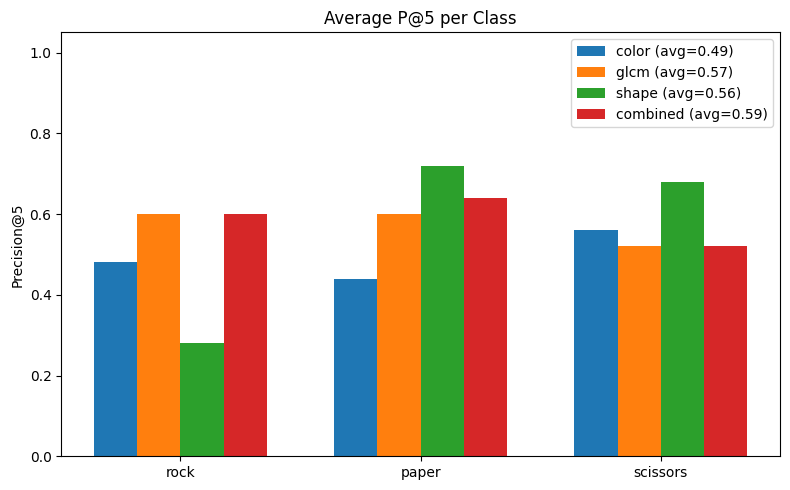

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def evaluate_p5_queries_per_class(num_per_class=5, class_order=("rock","paper","scissors"), seed=42):

    if seed is not None:
        random.seed(seed)

    features = ["color", "glcm", "shape", "combined"]
    items_by_class = defaultdict(list)
    for path, cls in dataset:
        items_by_class[cls].append(path)


    scores = {f: defaultdict(list) for f in features}

    for feat in features:
        if feat == "color":
            db_feats = db_color_s
            q_fn = lambda q: sc_color.transform([extract_color_features(q)])[0]
        elif feat == "glcm":
            db_feats = db_tex_s
            q_fn = lambda q: sc_tex.transform([extract_texture_features(q)])[0]
        elif feat == "shape":
            db_feats = db_shape_s
            q_fn = lambda q: sc_shape.transform([extract_shape_features(q)])[0]
        else:
            db_feats = db_combined
            q_fn = lambda q: np.concatenate([
                WEIGHT_COLOR  * sc_color.transform([extract_color_features(q)])[0],
                WEIGHT_TEXTURE* sc_tex.transform([extract_texture_features(q)])[0],
                WEIGHT_SHAPE  * sc_shape.transform([extract_shape_features(q)])[0],
            ])

        print(f"\nEvaluating feature: {feat.upper()}")

        for cls in class_order:
            pool = items_by_class.get(cls, [])
            if not pool:
                continue

            picks = random.sample(pool, min(len(pool), num_per_class))
            while len(picks) < num_per_class:
                picks.append(random.choice(pool))

            for p in picks:
                q_img = imread_rgb(p)
                q_feat = q_fn(q_img)
                ranked = rank(db_feats, q_feat, TOP_K, USE_COSINE)
                p5 = sum(db_meta[idx][1] == cls for idx, _ in ranked) / TOP_K
                scores[feat][cls].append(p5)
                print(f"{cls:10s} | {os.path.basename(p):20s} | P@5 = {p5:.2f}")


    per_class_avg = {f: {cls: np.mean(vals) for cls, vals in d.items()} for f, d in scores.items()}
    macro_avg = {f: np.mean(list(v.values())) for f, v in per_class_avg.items()}


    print("\nAverage Precision@5 per Class:")
    table = []
    for cls in class_order:
        row = [cls] + [f"{per_class_avg[f].get(cls, np.nan):.2f}" for f in features]
        table.append(row)
    print(pd.DataFrame(table, columns=["Class", "Color", "GLCM", "Shape", "Combined"]))
    print("\nMacro Averages:", {k: f"{v:.3f}" for k, v in macro_avg.items()})

    plt.figure(figsize=(8,5))
    x = np.arange(len(class_order))
    width = 0.18
    offsets = [-1.5, -0.5, 0.5, 1.5]

    for i, f in enumerate(features):
        vals = [per_class_avg[f].get(c, 0) for c in class_order]
        plt.bar(x + offsets[i]*width, vals, width, label=f"{f} (avg={macro_avg[f]:.2f})")

    plt.xticks(x, class_order)
    plt.ylim(0, 1.05)
    plt.ylabel("Precision@5")
    plt.title("Average P@5 per Class")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return per_class_avg, macro_avg

per_class_avg, macro_avg = evaluate_p5_queries_per_class(num_per_class=5)
